This notebook is my own correction of the [exercise 8, lesson 3](https://www.udacity.com/course/viewer#!/c-ud359/l-732399471/e-747978770/m-747978771), from the Udacity Introduction to Data Science course. The purpose of this exercise is to improve the linear regression computed from the gradient descent.

This command is required to display the plots inline:

In [1]:
%matplotlib inline

Import the tools for the exercise:

In [2]:
import numpy as np
import statsmodels.api as sm
from pandas import *
from ggplot import *

And now import the dataset as a ``pandas`` dataframe:

In [3]:
turnstile_weather = pandas.read_csv('data/turnstile_data_master_with_weather.csv')
print turnstile_weather.columns

Index([u'Unnamed: 0', u'UNIT', u'DATEn', u'TIMEn', u'Hour', u'DESCn',
       u'ENTRIESn_hourly', u'EXITSn_hourly', u'maxpressurei', u'maxdewpti',
       u'mindewpti', u'minpressurei', u'meandewpti', u'meanpressurei', u'fog',
       u'rain', u'meanwindspdi', u'mintempi', u'meantempi', u'maxtempi',
       u'precipi', u'thunder'],
      dtype='object')


To compare the results, we will use the $R^2$ function from the course:

In [4]:
def compute_r_squared(data, predictions):
    '''
    Given a list of original data points, and also a list of predicted data points,
    calculate the coefficient of determination (R^2) for this data.
    '''
    r_squared = 1 - np.square(data - predictions).sum() / np.square(data - data.mean()).sum()
    return r_squared

We can now select the features (independent variable) and the values (dependent variable).

In [5]:
features = turnstile_weather[['rain', 'precipi', 'Hour', 'mintempi', 'fog']]
values = turnstile_weather['ENTRIESn_hourly']

Before moving forward, let's have a look at the data and display the most import ones. It is always a good idea to plot quickly the data points to have a better feeling of the situation.

In [6]:
print turnstile_weather[['UNIT', 'DATEn', 'TIMEn', 'precipi', 'ENTRIESn_hourly']]

        UNIT       DATEn     TIMEn  precipi  ENTRIESn_hourly
0       R001  2011-05-01  01:00:00     0.00                0
1       R001  2011-05-01  05:00:00     0.00              217
2       R001  2011-05-01  09:00:00     0.00              890
3       R001  2011-05-01  13:00:00     0.00             2451
4       R001  2011-05-01  17:00:00     0.00             4400
5       R001  2011-05-01  21:00:00     0.00             3372
6       R002  2011-05-01  01:00:00     0.00                0
7       R002  2011-05-01  05:00:00     0.00               42
8       R002  2011-05-01  09:00:00     0.00               50
9       R002  2011-05-01  13:00:00     0.00              316
10      R002  2011-05-01  17:00:00     0.00              633
11      R002  2011-05-01  21:00:00     0.00              639
12      R003  2011-05-01  00:00:00     0.00                0
13      R003  2011-05-01  04:00:00     0.00                0
14      R003  2011-05-01  12:00:00     0.00                0
15      R003  2011-05-01

In [7]:
print np.mean(turnstile_weather[turnstile_weather['DATEn'] == '2011-05-30']['precipi'])

0.29


To be noticed, the precipitation value is the same for all stations for a given day. The plot of the precipitation by number of entries gives a cloud of points, that does not make think about a potential regression.

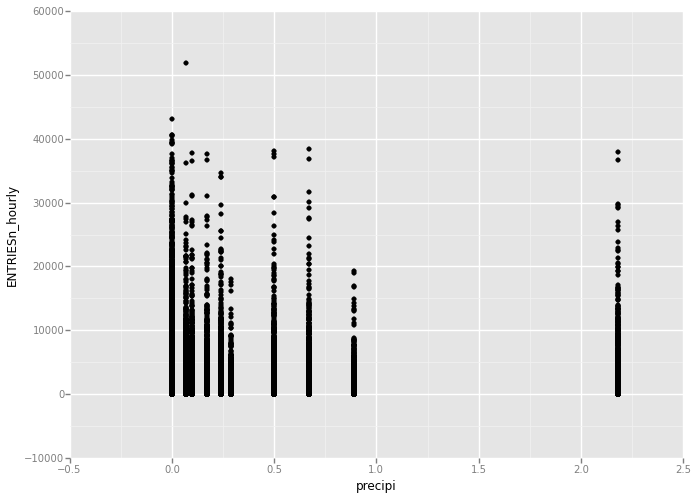

<ggplot: (277181233)>


In [8]:
plot = ggplot(aes('precipi', 'ENTRIESn_hourly'), turnstile_weather) + geom_point()
print plot

This is definitively not a good data points cloud for a linear regression. I did not notice it at first, but there is a subtle transformation in the stub of the exercise.

In [9]:
dummy_units = pandas.get_dummies(turnstile_weather['UNIT'], prefix='unit')
features = features.join(dummy_units)

This ``get_dummies`` function will convert the ``UNIT`` (stations) into indicator variables. So the linear regression will consider each station as a variable by itself, and no longer as a category of a single variable. The values are also normalized.

In [10]:
def normalize_features(df):
    mu = df.mean()
    sigma = df.std()    
    if (sigma == 0).any():
        raise Exception("One or more features had the same value for all samples, and thus could " + \
                         "not be normalized. Please do not include features with only a single value " + \
                         "in your model.")
    df_normalized = (df - df.mean()) / df.std()
    return df_normalized, mu, sigma
features, mu, sigma = normalize_features(features)

In the final step, the intercep is appended to the data, and converted into numpy array.

In [11]:
m = len(values)
features['ones'] = np.ones(m)
features_array = np.array(features)
values_array = np.array(values)

After this preparation work, we can determine the regression parameters. Let's start with the gradient descent.

In [12]:
def gradient_descent(features, values, theta, alpha, num_iterations):
    m = len(values)
    for i in range(num_iterations):
        predicted_values = np.dot(features, theta)
        theta = theta - alpha / m * np.dot((predicted_values - values), features)     
    return theta

In [13]:
alpha = 0.1
num_iterations = 75
theta_gradient_descent = np.zeros(len(features.columns))
theta_gradient_descent = gradient_descent(features_array,
                                          values_array,
                                          theta_gradient_descent,
                                          alpha,
                                          num_iterations)
prediction = np.dot(features_array, theta_gradient_descent)

In [14]:
print compute_r_squared(values_array, prediction)

0.458583922399


Let's try to determine the parameters with the `statsmodels` implementation.

In [15]:
model = sm.OLS(values_array, features_array)
theta_statsmodels = model.fit().params
prediction = np.dot(features_array, theta_statsmodels)    

In [16]:
print compute_r_squared(values_array, prediction)

0.458477825047


The result is about the same, which is expected and prove that the `statsmodels` implementation has been used properly. This implementation is convenient, since the parameters are provided by a single function call. This solution is accepted by the grader, even if the $R^2$ is not better than the gradient descent.